# Kwantyzacja kolorów

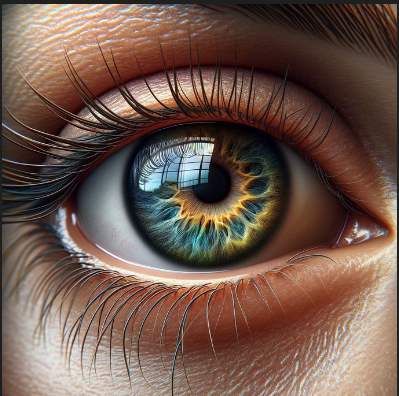


## Wstęp
Standardowy kolorowy obraz rozmiarów $n \times m$ jest reprezentowany przez $n \cdot m \cdot 3$ liczb całkowitych z przedziału $[0, 255]$. Daje to łącznie ponad 16 milionów możliwych kolorów. Kwantyzacja kolorów polega na drastycznym zredukowaniu liczby używanych kolorów w celu redukcji rozmiaru pliku, przy jednoczesnym jak najlepszym zachowaniu jakości obrazu.
Najprostszą metodą kwantyzacji jest użycie metody $k$-means. Działa znakomicie jeśli chodzi o redukcję kolorów, jednak jej natura wpływa też na ostateczny wygląd obrazka:
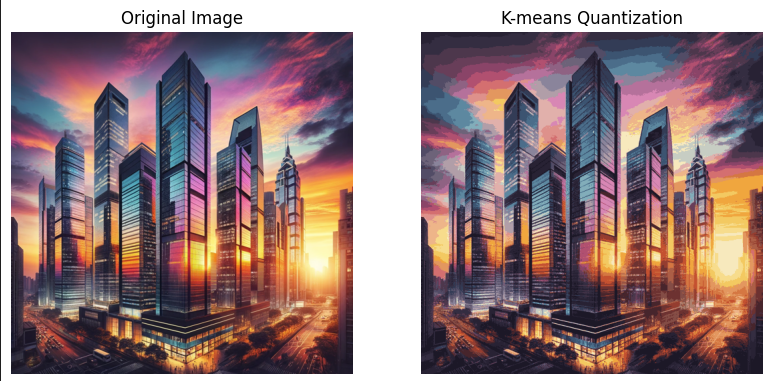


Metoda ([$k$-means](https://en.wikipedia.org/wiki/K-means_clustering)) kwantyzuje obraz minimalizując błąd średniokwadratowy ([mean squared error - MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) pomiędzy oryginalnym a zrekonstruowanym obrazkiem. 
Jednakże zupełnie nie obchodzi jej jakich kolorów ostatecznie użyje. Okazuje się jednak, że jeśli narzucimy koszty użycia kolorów to będziemy w stanie wpłynąć na jakość kwantyzacji. Wtedy jednak metoda $k$-means nie będzie już optymalna.

Zmiana metody kwantyzacji może więc wpłynąć na ostateczną jakość skwantyzowanego obrazu. I o tym właśnie jest poniższe zadanie.


## Zadanie

Celem zadania jest napisanie algorytmu klasteryzacji, który minimalizuje inną funkcję celu niż $k$-means.
Na początek zdefiniujmy sobie *koszt koloru*. Kolor RGB rozumiemy jako wektor trójwymiarowy ze zbioru $[0,1,...,255]^3$, a koszt koloru $c$ zdefiniujemy jako
odległość euklidesową od najbliższego "prostego" koloru w przestrzeni RGB, gdzie prostymi kolorami nazywamy: czarny $(0,0,0)$, biały $(255,255,255)$, czerwony $(255,0,0)$, zielony $(0,255,0)$, niebieski $(0,0,255)$, żółty $(255,255,0)$, magenta $(255,0,255)$ oraz cyjan $(0,255,255)$. Szczegóły znajdziesz w funkcji `color_cost`.
Z tak zdefiniowaną funkcją kosztu najbardziej kosztowny kolor to $(127,127,127)$, czyli szary. 
Interpretacja tej funkcji kosztu jest więc taka, że będziemy chcieli wymusić na algorytmie kwantyzacji, aby preferował kolory, które są bardziej jaskrawe i żywe.

Naszą funkcją celu będzie ważona suma poszczególnych składników:
1. `MSE`: błąd średniokwadratowy pomiędzy oryginalnym a zrekonstruowanym obrazkiem --- ten składnik odpowiada za to, żeby skwantyzowany obraz był bliski oryginałowi.
2. `total_color_cost`: suma kosztów wszystkich użytych kolorów --- ten składnik wymusza, aby użyte kolory były średnio odpowiednio jaskrawe.
3. `max_color_cost`: największy z kosztów użytych kolorów --- ten składnik wzmacnia jaskrawość kolorów, poprzez kontrolę najmniej jaskrawego koloru.

Ostatecznym kryterium jakości kwantyzacji będzie $$2\cdot MSE  + \frac{3}{2}max\_color\_cost + \frac{4}{3}total\_color\_cost.$$

Powyższe kryterium i wszystkie funkcje, o których powyżej jest mowa, są zaimplementowane poniżej przez nas. 

W zadaniu zakładamy, że liczba kolorów jest z góry ustalona i wynosi $37$. Twój algorytm ma więc skwantyzować obraz na $37$ kolorów w taki sposób, aby zminimalizować powyższą funkcję celu.


## Ograniczenia
- W tym zadaniu możesz korzystać z GPU.
- Twoja funkcja powinna zwracać 5 skwantyzowanych obrazów w maksymalnie 3 minuty używając Google Colab z GPU.
- Zarówno oryginalny i skwantyzowany obrazek powinny być podane do funkcji ewaluacyjnej jako `np.array` typu `np.uint8` z wartościami z przedziału $[0, 255]$.

## Uwagi i wskazówki
- Każdy obrazek to indywidualny zbiór treningowy; podczas ewaluacji nie będą wczytywane żadne wagi wytrenowanych przez Ciebie modeli.
- Będziesz pracować na obrazach wygenerowanych przez DALL-E oraz Stable Diffusion.
- W funkcji `your_quantization_algorithm` należy ustawić seeda, aby wyniki otrzymane na zbiorze treningowym i walidacyjnym przenosiły się na testowy.

## Pliki zgłoszeniowe
Tylko ten notebook.

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `evaluation_script.py` będziesz mógł upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających. 

Za to zadanie możesz zdobyć pomiędzy 0 i 1.5 punktu. Jeśli dostaniesz score powyżej 6500, to dostaniesz 0, a jeśli poniżej 5600, to dostaniesz 1.5 punktu. Pomiędzy tymi wartościami, Twój wynik rośnie liniowo z wartością score.



# Kod startowy

In [21]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################
FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [22]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import typing

import glob

## Ładowanie danych

In [23]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Klasa, która ułatwia wczytywanie obrazków z danego folderu
class ImageDataset:
    def __init__(self, image_dir: str):
        self.filelist = glob.glob(image_dir + "/*.jpg")
        self.IMAGE_DIMS = (512, 512)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx) -> np.ndarray:
        with Image.open(self.filelist[idx]) as image:
            image = image.convert('RGB')
            image = image.resize(self.IMAGE_DIMS)
            return np.array(image)

    def __iter__(self) -> typing.Iterator[np.ndarray]:
        return (self[i] for i in range(len(self.filelist)))

## Kod z kryterium oceniającym

In [24]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Poniżej znajdziesz definicje MSE oraz kosztu użycia kolorów
# Pamiętaj, żeby przy ewaluacji liczyć je w przestrzeni RGB, tzn. na wartościach całkowitych z przdziału [0, 255]
# Skalowanie jest dopuszczalne tylko podczas treningu!

# Zdefiniujmy kryterium oceny jakości kwantyzacji
# Użyjemy do tego błędu średniokwadratowego (mean square error - MSE)
def mse(img, img_quant):
  return ((img_quant.astype(np.float32) - img.astype(np.float32))**2).mean()


# Następnie zdefinujmy koszt użycia kolorów
# Im bliżej danemu kolorowi do "prostych" kolorów, tym mniejszy koszt jego użycia
def color_cost(img_quant):
    vertices = np.array([
        [0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255],
        [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]
    ])
    colors = np.unique(img_quant.reshape(-1,3), axis=0)
    
    differences = colors[:, np.newaxis, :] - vertices[np.newaxis, :, :]
    squared_distances = np.sum(differences**2, axis=2)
    costs = np.sqrt(np.min(squared_distances, axis=1))

    return np.sum(costs), np.max(costs)


# Całkowite kryterium zdefiniowane w treści zadania
def quantization_score(img, img_quant):
    assert img.dtype == np.uint8
    assert img_quant.dtype == np.uint8
    
    mse_cost = mse(img, img_quant)
    total_color_cost, max_color_cost = color_cost(img_quant)
    score = mse_cost * 2 + max_color_cost*(3/2) + total_color_cost *(4/3)
    print(f'MSE: {mse_cost:.4f}, max_color_cost: {max_color_cost:.4f}, total_color_cost: {total_color_cost:.4f}')
    print(f'Score: {score:.4f}')
    return score

## Przykładowe rozwiązanie
Poniżej prezentujemy proste rozwiązanie, które w oczywisty sposób nie jest optymalne. Służy temu, aby było wiadomo w jaki sposób ma działać cały notatnik.

In [25]:
from sklearn.cluster import KMeans

if not FINAL_EVALUATION_MODE:
    # Kwantyzuje obraz poprzez zaokrąglenie wszystkich wartości do 0 lub 255
    def starter_quantization_algorithm(img):
        # Reshape the image to a 2D array of pixels and 3 color values (RGB)
        pixels = img.reshape(-1, 3)
        # Fit KMeans to the data
        kmeans = KMeans(n_clusters=37, random_state=0).fit(pixels)
        # Get the colors of the clusters
        colors = kmeans.cluster_centers_
        # Get the labels of the clusters for all pixels
        labels = kmeans.predict(pixels)
        # Create the quantized image
        quantized_image = colors[labels].reshape(img.shape)
        return quantized_image.astype(np.uint8)


In [26]:
# Wyświetl zestawienie oryginału i zkwantyzowanego obrazka
def show_quantization_results(original, quantized):
        _, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(original)
        ax[0].set_title("Oryginał")
        ax[0].axis("off")

        ax[1].imshow(quantized)
        ax[1].set_title("Wynik kwantyzacji")
        ax[1].axis("off")
        plt.show()

MSE: 318.4507, max_color_cost: 164.7968, total_color_cost: 4470.2075
Score: 6844.3732


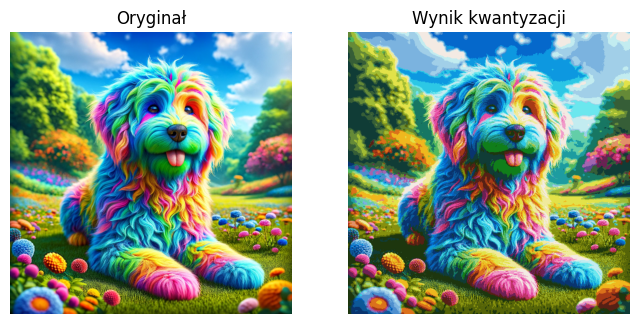

In [27]:
if not FINAL_EVALUATION_MODE:
    for image in ImageDataset('valid_data'):
        # Skwantyzujmy zdjęcie
        quantized_image = starter_quantization_algorithm(image)
        # Policzmy wynik dla otrzymanej kwantyzacji
        score = quantization_score(image, quantized_image)
        # Zobaczmy jak wygląda skwantywzowane zdjęcie
        show_quantization_results(image, quantized_image)
        break

# Twoje rozwiązanie

Ta sekcja to miejsce na Twoje rozwiązanie. Tylko tutaj powinieneś wprowadzać zmiany!

In [28]:
def your_quantization_algorithm(img):
    #TODO - zaimplementuj swój algorytm kwantyzacji
    return img

# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas zostanie wykonana funkcja `evaluate_algorithm(your_quantization_algorithm, 'test_data')`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu zdjęć `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [29]:
def evaluate_algorithm(quantization_algorithm, data_dir):
    dataset = ImageDataset(data_dir)
    scores = []
    for image in dataset:
        quantized_image = quantization_algorithm(image)
        show_quantization_results(image, quantized_image)
        score = quantization_score(image, quantized_image)
        scores.append(score)
    return np.mean(scores)

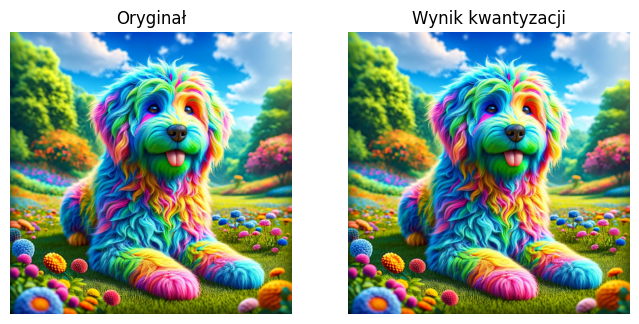

MSE: 0.0000, max_color_cost: 215.3718, total_color_cost: 27166185.8376
Score: 36221904.1744


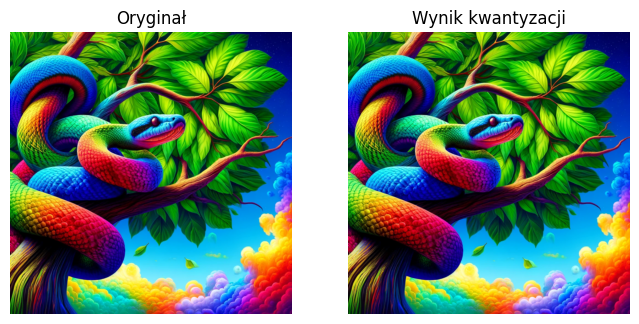

MSE: 0.0000, max_color_cost: 217.6626, total_color_cost: 19391285.7140
Score: 25855374.1126


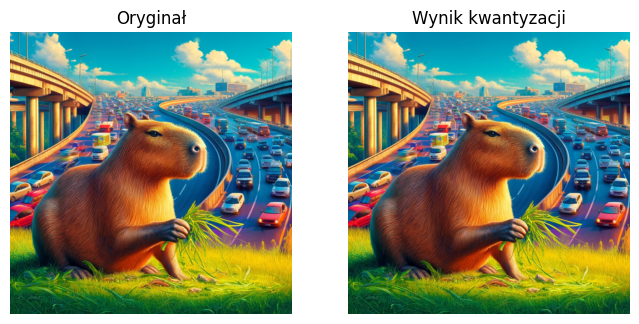

MSE: 0.0000, max_color_cost: 218.8173, total_color_cost: 26038812.9603
Score: 34718745.5063


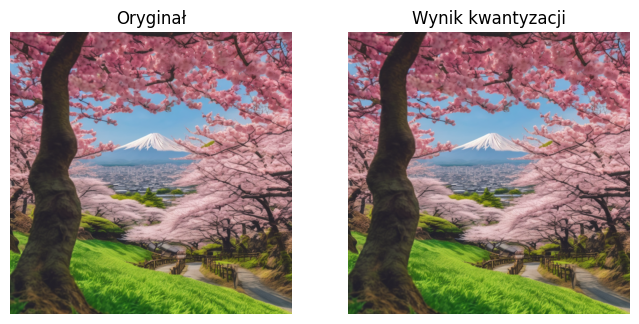

MSE: 0.0000, max_color_cost: 219.3946, total_color_cost: 22932854.8821
Score: 30577468.9347


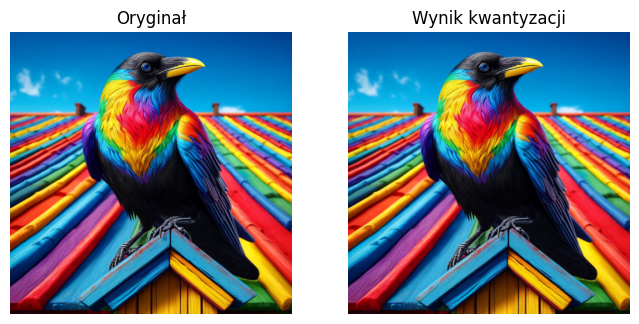

MSE: 0.0000, max_color_cost: 218.8218, total_color_cost: 17779664.6410
Score: 23706547.7542


In [30]:
if not FINAL_EVALUATION_MODE:
    evaluate_algorithm(your_quantization_algorithm, 'valid_data')
